In [1]:
# LSTM RNN model is used to examine model performance with two data sets with contrasting behavior
# Data: 
    # dataset 1: used cars monthly sales in millions of dolars from 1992-01-01 to 2019-12-01
        # https://fred.stlouisfed.org/series/MRTSSM44112USN
    # dataset 2: gold price daily in USD from 2015-02-23 to 2020-02-21
        # https://fred.stlouisfed.org/series/GOLDPMGBD228NLBM
# Note: Here we use GPU computing, so processing time will be different for those who use CPU computing

In [2]:
# import libraries

import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%matplotlib inline
sns.set(style = "whitegrid", font_scale = 1.2)

# for plotting datetime values with matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# ignore non-critical warnings
import warnings
warnings.filterwarnings("ignore")

# check if GPU computing with CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# read dataset 1 csv file

data_1 = pd.read_csv('used_car_sales.csv', index_col = 0, parse_dates = True) # set date column as index
data_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 336 entries, 1992-01-01 to 2019-12-01
Data columns (total 1 columns):
MRTSSM44112USN    336 non-null int64
dtypes: int64(1)
memory usage: 5.2 KB


In [4]:
# there are 336 non-null entries of type int64

In [5]:
# call first 10 entries

data_1.head(10)

,MRTSSM44112USN
DATE,
1992-01-01,1744
1992-02-01,1990
1992-03-01,2177
1992-04-01,2601
1992-05-01,2171
1992-06-01,2207
1992-07-01,2251
1992-08-01,2087
1992-09-01,2016


In [6]:
# call last 10 entries

data_1.tail(10)

,MRTSSM44112USN
DATE,
2019-03-01,11525
2019-04-01,10009
2019-05-01,10223
2019-06-01,9770
2019-07-01,9916
2019-08-01,9998
2019-09-01,9043
2019-10-01,9326
2019-11-01,8969


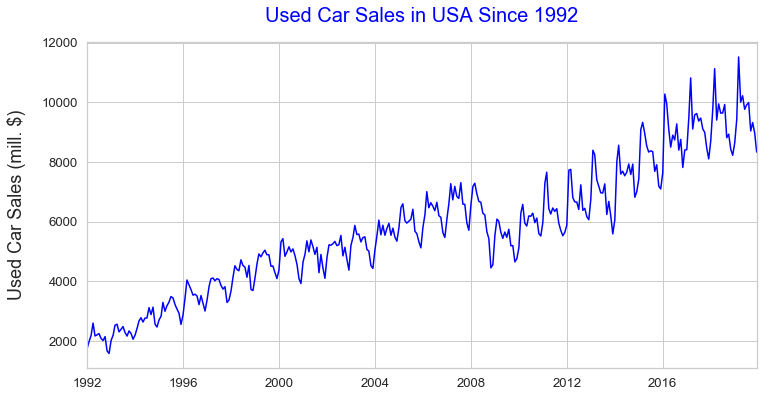

In [7]:
# plot data

plt.figure(figsize = (12,6))
plt.plot(data_1.index, data_1['MRTSSM44112USN'], c = 'blue')
plt.autoscale(axis='x',tight=True)
plt.ylabel('Used Car Sales (mill. $)', fontsize = 18, labelpad = 15)
plt.title('Used Car Sales in USA Since 1992', fontsize = 20, pad = 20, color ='blue')
plt.show()

In [8]:
# plot shows highly cyclical data with a yearly cycle
# the big drop at 2008 corresponds to the 2008-2009 reccession

In [9]:
# read dataset 2 csv file

data_2 = pd.read_csv('GOLDPMGBD228NLBM.csv', index_col = 0, parse_dates = True) # set date column as index

data_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1305 entries, 2015-02-23 to 2020-02-21
Data columns (total 1 columns):
GOLDPMGBD228NLBM    1305 non-null object
dtypes: object(1)
memory usage: 20.4+ KB


In [10]:
# data have 1305 entries
# the data have missing entries since five years will result in 5 * 365 = 1825 data points

In [11]:
# call first 10 entries

data_2.head(10)

,GOLDPMGBD228NLBM
DATE,
2015-02-23,1204.500
2015-02-24,1192.500
2015-02-25,1204.750
2015-02-26,1208.250
2015-02-27,1214.000
2015-03-02,1212.500
2015-03-03,1212.750
2015-03-04,1199.500
2015-03-05,1202.000


In [12]:
# call last 10 entries

data_2.tail(10)

,GOLDPMGBD228NLBM
DATE,
2020-02-10,1573.20
2020-02-11,1570.50
2020-02-12,1563.70
2020-02-13,1575.05
2020-02-14,1581.40
2020-02-17,1580.80
2020-02-18,1589.85
2020-02-19,1604.20
2020-02-20,1619.00


In [13]:
# select gold prices column to work with

y = data_2.iloc[:, -1].values
y

array(['1204.500', '1192.500', '1204.750', ..., '1604.20', '1619.00',
       '1643.30'], dtype=object)

In [14]:
# gold price values are in string format --> need to convert to floats
# however, strings of the type 'x.y' cannot be converted directly 
# we will use split('.') and select only the digits before the decimal point
    # all values are >= 1000, thus the error introduced is negligible

In [15]:
# convert from strings to floats and at the same time check for missing values and impute

count_null = 0 # set counter for null values

for i in range(len(y)):
    if y[i] == '.':
        y[i] = round(np.mean(y[i-10: i]), 1) # impute with 10-day running avg
        count_null = count_null + 1 # update null counter
    
    else:
        y[i] = y[i].split('.')[0] # split the string at '.' and drop the digits after the decimal point
        y[i] = float(y[i])
    
    print(i)
    print(y[i])

0
1204.0
1
1192.0
2
1204.0
3
1208.0
4
1214.0
5
1212.0
6
1212.0
7
1199.0
8
1202.0
9
1175.0
10
1168.0
11
1162.0
12
1150.0
13
1152.0
14
1152.0
15
1150.0
16
1150.0
17
1147.0
18
1166.0
19
1183.0
20
1186.0
21
1191.0
22
1195.0
23
1203.0
24
1195.0
25
1185.0
26
1187.0
27
1197.0
28
1198.0
29
1192.0
30
1192.9
31
1211.0
32
1207.0
33
1194.0
34
1207.0
35
1198.0
36
1194.0
37
1192.0
38
1204.0
39
1203.0
40
1196.0
41
1195.0
42
1189.0
43
1185.0
44
1183.0
45
1200.0
46
1209.0
47
1209.0
48
1180.0
49
1175.0
50
1192.1
51
1197.0
52
1194.0
53
1187.0
54
1186.0
55
1189.0
56
1191.0
57
1210.0
58
1225.0
59
1220.0
60
1223.0
61
1214.0
62
1210.0
63
1205.0
64
1204.0
65
1209.1
66
1185.0
67
1185.0
68
1185.0
69
1191.0
70
1199.0
71
1192.0
72
1190.0
73
1176.0
74
1164.0
75
1172.0
76
1177.0
77
1188.0
78
1178.0
79
1182.0
80
1181.0
81
1177.0
82
1178.0
83
1201.0
84
1203.0
85
1185.0
86
1178.0
87
1173.0
88
1172.0
89
1170.0
90
1176.0
91
1171.0
92
1168.0
93
1165.0
94
1167.0
95
1166.0
96
1156.0
97
1158.0
98
1164.0
99
1159.0
100
1154.0

972
1203.0
973
1211.0
974
1222.0
975
1221.0
976
1223.0
977
1226.0
978
1227.0
979
1223.0
980
1223.0
981
1221.0
982
1213.0
983
1226.0
984
1217.0
985
1230.0
986
1240.0
987
1235.0
988
1242.0
989
1243.0
990
1245.0
991
1245.0
992
1245.0
993
1242.0
994
1235.0
995
1241.0
996
1246.0
997
1255.0
998
1259.0
999
1258.0
1000
1247.1
1001
1247.3
1002
1247.5
1003
1268.0
1004
1279.0
1005
1254.8
1006
1256.2
1007
1282.0
1008
1290.0
1009
1279.0
1010
1292.0
1011
1286.0
1012
1288.0
1013
1291.0
1014
1288.0
1015
1292.0
1016
1294.0
1017
1292.0
1018
1290.0
1019
1284.0
1020
1279.0
1021
1282.0
1022
1279.0
1023
1283.0
1024
1293.0
1025
1302.0
1026
1307.0
1027
1310.0
1028
1323.0
1029
1318.0
1030
1312.0
1031
1314.0
1032
1312.0
1033
1310.0
1034
1314.0
1035
1306.0
1036
1310.0
1037
1312.0
1038
1311.0
1039
1316.0
1040
1325.0
1041
1334.0
1042
1343.0
1043
1331.0
1044
1329.0
1045
1331.0
1046
1325.0
1047
1322.0
1048
1319.0
1049
1311.0
1050
1285.0
1051
1283.0
1052
1285.0
1053
1285.0
1054
1296.0
1055
1292.0
1056
1297.0
1057
130

In [16]:
# print total null count
print(f'Total Null Count: {count_null}')

Total Null Count: 53


In [17]:
# number of nulls is 53 which is small relative to the total number of data points

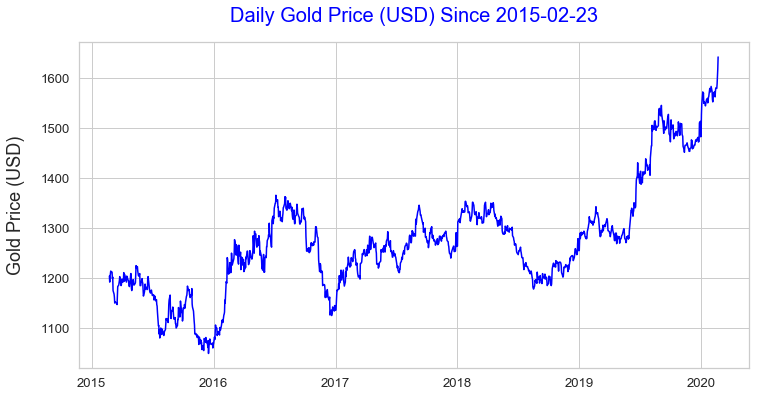

In [18]:
# plot gold prices

plt.figure(figsize = (12,6))
plt.plot(data_2.index, y, color = 'blue')
plt.ylabel('Gold Price (USD)', fontsize = 18, labelpad = 15)
plt.title('Daily Gold Price (USD) Since 2015-02-23', fontsize = 20, pad = 20, color ='blue')
plt.show()

In [19]:
# in contrast with dataset 1, values here do not have clear cyclical nature and rather resemble "random walk"

In [20]:
# Prepare data

In [21]:
# get values from both datasets assigned as y_1 and y_2

# values from dataset 1
y_1 = data_1.iloc[:, -1].values.astype(float)

# values from dataset 2
y_2 = y[0:1290] 
# for convenience we select 1290 out of 1305 points to use with a window size of 30 (one month) later on

In [22]:
# create train and test sets from y_1 and y_2

# dataset 1
test_size_1 = 12 # test size corresponds to 1 year

train_set_1 = y_1[:-test_size_1]
test_set_1 = y_1[-test_size_1:]

# dataset 2
test_size_2 = 30 # test size corresponds to 1 month

train_set_2 = y_2[:-test_size_2]
test_set_2 = y_2[-test_size_2:]

In [23]:
# NNs perform better with normalized data --> normalize data using MinMaxScaler
    # normalize train_set only to avoid information leakage from test_set

from sklearn.preprocessing import MinMaxScaler

# instantiate a scaler with a feature range from -1 to 1
scaler_1 = MinMaxScaler(feature_range=(-1, 1)) # for dataset 1
scaler_2 = MinMaxScaler(feature_range=(-1, 1)) # for dataset 2

In [24]:
# normalize the training sets

train_set_1 = scaler_1.fit_transform(train_set_1.reshape(-1, 1))

train_set_2 = scaler_2.fit_transform(train_set_2.reshape(-1, 1))

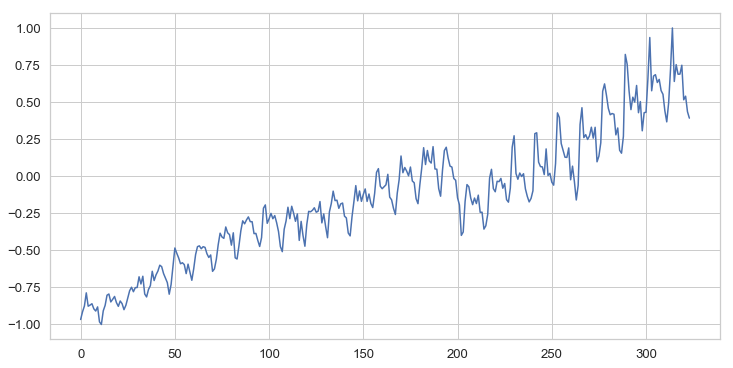

In [25]:
# plot normalized train set 1

plt.figure(figsize = (12,6))
plt.plot(train_set_1)
plt.show()

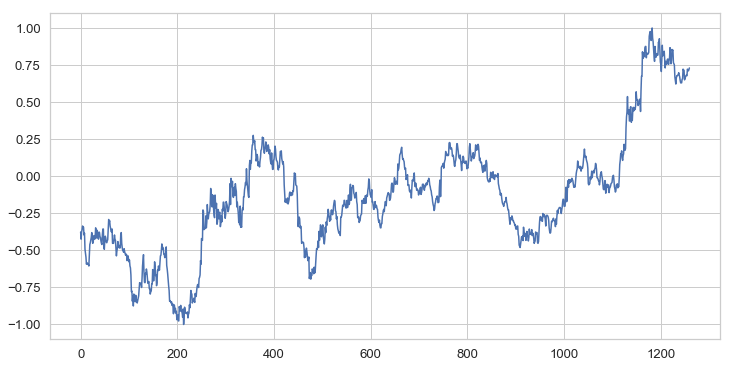

In [26]:
# plot normalized train set 2

plt.figure(figsize = (12,6))
plt.plot(train_set_2)
plt.show()

In [27]:
# normalized data is bound within -1 and 1, while preserving the ratio between data points

In [28]:
# Prepare data for LSTM model

In [29]:
# convert train_set_1 and train_set_2 to tensors and set window sizes for both sets
train_set_1 = torch.FloatTensor(train_set_1).view(-1)
train_set_2 = torch.FloatTensor(train_set_2).view(-1)

# window size for dataset 1
window_size_1 = 12 # 1 year

# window size for dataset 2
window_size_2 = 30 # 1 month

In [30]:
# define function to create seq/label tuples

def input_data(seq, ws):  # ws is the window size
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window, label))
    return out

In [31]:
# apply the input_data function to train_set_1 and train_set_2

train_data_1 = input_data(train_set_1, window_size_1)
train_data_2 = input_data(train_set_2, window_size_2)

In [32]:
len(train_data_1)  # this should equal 336 - 12 - 12

312

In [33]:
# show first element of train_data_1
train_data_1[0]

(tensor([-0.9663, -0.9148, -0.8756, -0.7868, -0.8768, -0.8693, -0.8601, -0.8944,
         -0.9093, -0.8815, -0.9824, -1.0000]),
 tensor([-0.9081]))

In [34]:
# first tensor is the input data for the model
# second tensor is the target value to be predicted by model based on input data

In [35]:
len(train_data_2)  # this should equal 1290 - 30 - 30

1230

In [36]:
# show first element of train_data_2
train_data_2[0]

(tensor([-0.3763, -0.4245, -0.3763, -0.3602, -0.3360, -0.3441, -0.3441, -0.3964,
         -0.3843, -0.4930, -0.5211, -0.5453, -0.5936, -0.5855, -0.5855, -0.5936,
         -0.5936, -0.6056, -0.5292, -0.4608, -0.4487, -0.4286, -0.4125, -0.3803,
         -0.4125, -0.4527, -0.4447, -0.4044, -0.4004, -0.4245]),
 tensor([-0.4209]))

In [37]:
# Define the LSTM model

In [38]:
class LSTMnetwork(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 256, output_size = 1): # use LSTM layer of size 256
        super().__init__()
        self.hidden_size = hidden_size
        
        # add an LSTM layer:
        self.lstm = nn.LSTM(input_size, hidden_size)
        
        # add a fully-connected layer:
        self.linear = nn.Linear(hidden_size, output_size)
        
        # initialize h0 and c0 -- use .to(device) to select GPU or CPU computation, respectively
        self.hidden = (torch.zeros(1, 1, self.hidden_size).to(device),
                       torch.zeros(1, 1, self.hidden_size).to(device))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1]  # we only want the last value

In [39]:
# Training

In [40]:
# define train_model function to be used with the two datasets

def train_model(epochs, train_data):
    
    # instantiate model, define loss and optimization functions
    
    torch.manual_seed(42)
    model = LSTMnetwork().to(device) # set device at instantiation
    
    criterion = nn.MSELoss().to(device) # use MSE and set device
    
    # optimizer has to be defined after model has been associated with the device!
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # use Adam optimizer
    
    
    # start training
    
    start_time = time.time()
    for epoch in range(epochs):
        
        # extract the sequence & label from the training data
        for seq, y_train in train_data:
            
            # reset the parameters and hidden states -- use .to(device) to select GPU or CPU computation, respectively
            optimizer.zero_grad()
            model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device), 
                            torch.zeros(1, 1, model.hidden_size).to(device))
            y_pred = model(seq.to(device))
            
            loss = criterion(y_pred, y_train.to(device))
            loss.backward()
            optimizer.step()
            
        # print training result every 10 epochs starting with 1st epoch
        if epoch%10 == 0:
            print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    return model

In [41]:
# define model_predictions function to be used with both datasets

def model_predictions(model, future, preds, window_size):
    
    # set the model to evaluation mode
    model.eval()
    
    for i in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_size).to(device),
                            torch.zeros(1, 1, model.hidden_size).to(device))
            preds.append(model(seq.to(device)).item())

In [42]:
import time

epochs = 200

# train model with train_data_1
train_data = train_data_1

model_1 = train_model(epochs, train_data) # provide separate name for model in case it will be used later on

Epoch:  1 Loss: 0.02258122
Epoch: 11 Loss: 0.01771832
Epoch: 21 Loss: 0.00304347
Epoch: 31 Loss: 0.00054948
Epoch: 41 Loss: 0.01037953
Epoch: 51 Loss: 0.00080097
Epoch: 61 Loss: 0.00018010
Epoch: 71 Loss: 0.00063973
Epoch: 81 Loss: 0.00016539
Epoch: 91 Loss: 0.00000044
Epoch: 101 Loss: 0.00001165
Epoch: 111 Loss: 0.00004981
Epoch: 121 Loss: 0.00000134
Epoch: 131 Loss: 0.00000192
Epoch: 141 Loss: 0.00000058
Epoch: 151 Loss: 0.00008903
Epoch: 161 Loss: 0.00176829
Epoch: 171 Loss: 0.00005219
Epoch: 181 Loss: 0.00018570
Epoch: 191 Loss: 0.00011390

Duration: 277 seconds


In [43]:
# make predictions for train_set_1

future = 12
window_size = window_size_1
preds = train_set_1[-window_size:].tolist()
    
model_predictions(model_1, future, preds, window_size)

In [44]:
preds

[0.4943973124027252,
 0.7203895449638367,
 1.0,
 0.6391245126724243,
 0.7526442408561707,
 0.6879254579544067,
 0.6887632012367249,
 0.7486647963523865,
 0.5155513882637024,
 0.5398470759391785,
 0.4353335499763489,
 0.39176878333091736,
 0.5067726373672485,
 0.7620344758033752,
 0.9861121773719788,
 0.6068530082702637,
 0.7663792967796326,
 0.7105640172958374,
 0.679915189743042,
 0.6957989931106567,
 0.5026361346244812,
 0.4948640465736389,
 0.4121510982513428,
 0.3802984952926636]

In [45]:
# invert the normalization for the predicted values to be able to compare to test data

preds_1 = scaler_1.inverse_transform(np.array(preds[future:]).reshape(-1, 1)) # use the coresponding scaler

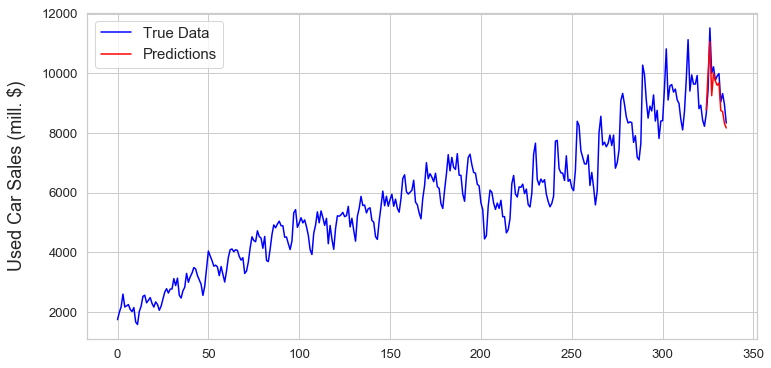

In [46]:
# plot y_1 and preds_1 to compare predictions to data

plt.figure(figsize = (12,6))
plt.plot(y_1, c = 'blue', label = 'True Data')
plt.plot(np.arange(len(y_1) - future, len(y_1)), preds_1, c = 'red', label = 'Predictions')
plt.ylabel('Used Car Sales (mill. $)', fontsize = 18, labelpad = 15)
plt.legend(fontsize = 15)
plt.show()

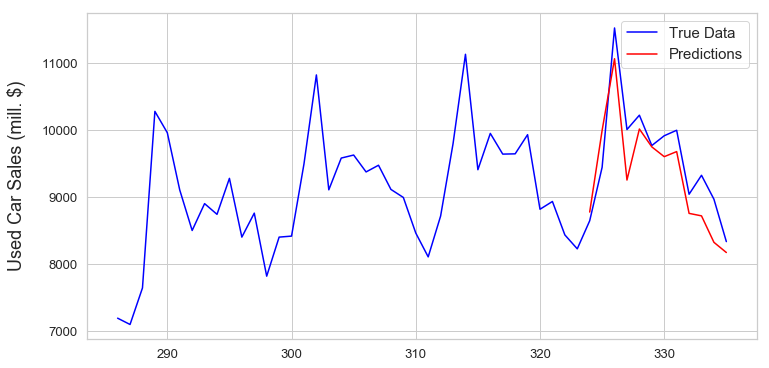

In [47]:
# plot only last portion of graph for more detail view

plt.figure(figsize = (12,6))
plt.plot(np.arange(len(y_1) - 50, len(y_1)), y_1[-50:], c = 'blue', label = 'True Data')
plt.plot(np.arange(len(y_1) - future, len(y_1)), preds_1, c = 'red', label = 'Predictions')
plt.ylabel('Used Car Sales (mill. $)', fontsize = 18, labelpad = 15)
plt.legend(fontsize = 15)
plt.show()

In [48]:
# model predictions matches well data
# we note, however, that similar result can be obtained simply by appropriate averaging and translating the closest data cycles

In [49]:
# repeat the same process with dataset 2

In [50]:
# train model with train_data_2
train_data = train_data_2

model_2 = train_model(epochs, train_data)

Epoch:  1 Loss: 0.00132558
Epoch: 11 Loss: 0.00002865
Epoch: 21 Loss: 0.00001599
Epoch: 31 Loss: 0.00171120
Epoch: 41 Loss: 0.00000009
Epoch: 51 Loss: 0.00002835
Epoch: 61 Loss: 0.00002389
Epoch: 71 Loss: 0.00090776
Epoch: 81 Loss: 0.00011469
Epoch: 91 Loss: 0.00009155
Epoch: 101 Loss: 0.00002225
Epoch: 111 Loss: 0.00004643
Epoch: 121 Loss: 0.00026000
Epoch: 131 Loss: 0.00033497
Epoch: 141 Loss: 0.00008077
Epoch: 151 Loss: 0.00012586
Epoch: 161 Loss: 0.00000982
Epoch: 171 Loss: 0.00009436
Epoch: 181 Loss: 0.00024117
Epoch: 191 Loss: 0.00010930

Duration: 1156 seconds


In [51]:
# make predictions for train_set_2

future = 30
window_size = window_size_2
preds = train_set_2[-window_size:].tolist()
    
model_predictions(model_2, future, preds, window_size)

In [52]:
# invert the normalization for the predicted values to be able to compare to test data

preds_2 = scaler_2.inverse_transform(np.array(preds[future:]).reshape(-1, 1)) # use the coresponding scaler

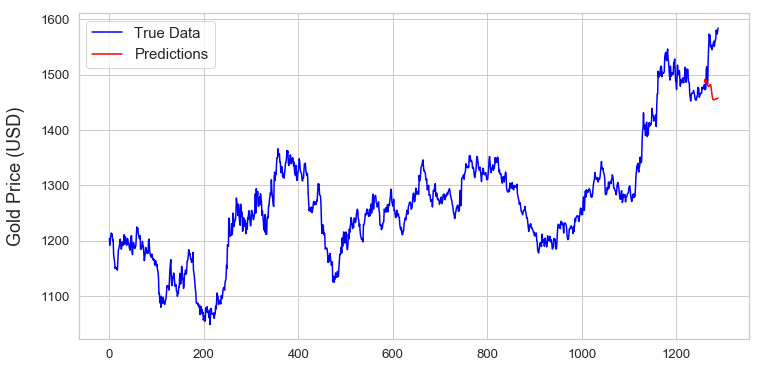

In [53]:
# plot y_2 and preds_2 to compare predictions to data

plt.figure(figsize = (12,6))
plt.plot(y_2, c = 'blue', label = 'True Data')
plt.plot(np.arange(len(y_2) - future, len(y_2)), preds_2, c = 'red', label = 'Predictions')
plt.ylabel('Gold Price (USD)', fontsize = 18, labelpad = 15)
plt.legend(fontsize = 15)
plt.show()

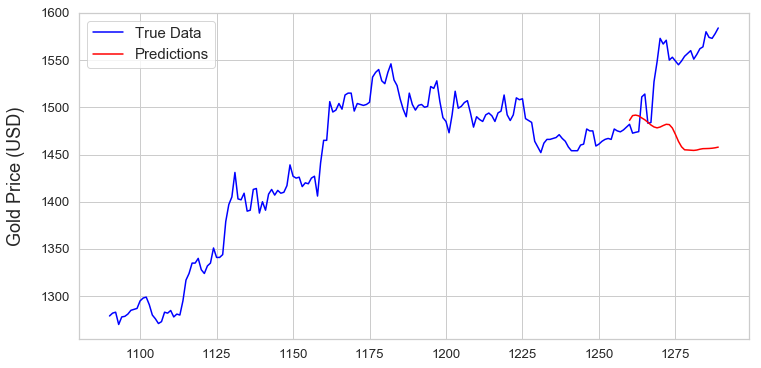

In [54]:
# plot only last portion of graph for more detail view

plt.figure(figsize = (12,6))
plt.plot(np.arange(len(y_2) - 200, len(y_2)), y_2[-200:], c = 'blue', label = 'True Data')
plt.plot(np.arange(len(y_2) - future, len(y_2)), preds_2, c = 'red', label = 'Predictions')
plt.ylabel('Gold Price (USD)', fontsize = 18, labelpad = 15)
plt.legend(fontsize = 15)
plt.show()

In [55]:
# predictions diverge dramatically from data
# extensive research on LSTM models used for predicting "random walk" type of data (e.g. stock prices) showed similar results

In [56]:
# Conclusion:
    # 1) LSTM model provides good predictions for data with well-defined cyclical behavior
            # we note that for such data much simpler mathematical operations would provide equally good predictions
        
    # 2) LSTM (and other versions of RNNs) model does not provide good predictions for data with random behavior
            # this finding is supported by numerous other studies
        
    # For data with random behavior different types of analysis are needed for providing good predictions (if at all possible)